In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

# Maths

The PDE describing peat surface elevation over time is

$$
\frac{\partial^2 u}{\partial t^2} + \alpha \frac{\partial u}{\partial t} = \frac{αT}{S_y}\nabla^2 p + \frac{α}{S_y}(P-ET),
$$
where $α$ is the peat accumulation or subsidence rate, and it comes from

$$
p_t = a_p - α ζ
$$
where $ζ$ is water table below homogeneous peat surface, and $a_p$ is constant peat accumulation rate when WTD is at the surface, i.e., $ζ=0$.

This PDE is analogous to a wave equation. In 1D:
$$
\frac{\partial^2 u}{\partial t^2} + b\frac{\partial u}{\partial t} = c^2\frac{\partial^2 u}{\partial x^2} + f_{ext}(x,t),
$$
where $b$ is the friction term and $f_{ext}$ is an external force that drives the system.



# 1D Numerics

  Very simple numerical scheme for the solution of the wave equation, given by eq. (23) of
  http://hplgit.github.io/INF5620/doc/notes/wave-sphinx/main_wave.html

In [3]:
# Parameters
dx = 1. # m
dt = 10

L = 1000 # m string length
MAX_NITER = int(5e3)
grid_length = int(L/dx)
simulated_time = int(dt*MAX_NITER)

b = 0.001 # friction term
c_squared = 1.0 # coefficient of wave
f_ext = 0.000001 * np.ones(shape=grid_length) # external force

In [4]:
# Numerical scheme

# A finite differences matrix
fin_diff_matrix = (np.diag(np.ones(shape=grid_length-1), k=-1) +
             np.diag(np.ones(shape=grid_length-1), k=+1) -
             np.diag(2*np.ones(shape=grid_length))) 

@njit
def run_one_timestep(u, u_old):
    return (1/(1 + 0.5*b*dt)*((0.5*b*dt - 1) * u_old +
                                2*u +
                                c_squared*(fin_diff_matrix @ u) +
                                 dt**2 * f_ext
                            )
           )
 
@njit 
def run_all_timesteps(u, u_old):
    solution = np.zeros(shape=(MAX_NITER, grid_length))
    solution[0] = u
    for niter in range(1, MAX_NITER):
        # Diri BC
        u[0] = DIRI_BC_LEFT
        u[grid_length-1] = DIRI_BC_RIGHT
        
        # Set a drainage canal. It's easy: fix p at some level.
        if niter > DRAINAGE_NITER:
            u[DRAINAGE_POSITION] = 1.
        
        u_new = run_one_timestep(u, u_old) #solve
        solution[niter] = u_new
        
        u_old = u.copy()
        u = u_new.copy()
        
    return solution  


In [5]:
# %% Solve
# Initial condition
u = np.zeros(shape=grid_length)
# Triangular
# u[:int(grid_length/2)] = np.linspace(start=0, stop=1., num=int(grid_length/2))
# u[int(grid_length/2):] = np.linspace(start=1., stop=0., num=int(grid_length/2))
                                      
# Diri BC
DIRI_BC_LEFT = 0
DIRI_BC_RIGHT = 0
# Diri BC at initial conditions
u[0] = DIRI_BC_LEFT
u[grid_length-1] = DIRI_BC_RIGHT
u_old = u.copy()

# Drainage
DRAINAGE_NITER = 300 # when to dig a ditch
DRAINAGE_POSITION = int(grid_length/4)

solution = run_all_timesteps(u, u_old) # This is the solution

# 1D Plots and animation

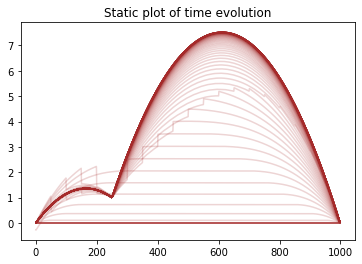

In [6]:
%matplotlib inline
# %% Plot
plt.figure()
plt.title('Static plot of time evolution')
for niter in range(0, MAX_NITER):
    if niter==0:
        plt.plot(solution[0], color='brown', alpha=1.0)
    if niter%int(MAX_NITER/100) == 0:  
        plt.plot(solution[niter], color='brown', alpha=0.2)



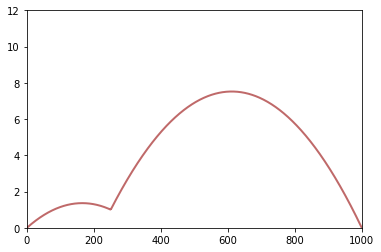

In [7]:
# %% Animate
from matplotlib.animation import FuncAnimation

INTERVAL = 100 # Interval to sample plotting times from solution. If = 1, all times are plotted
animation_solution = solution[::INTERVAL]
animation_niter = animation_solution.shape[0]

# initializing a figure in 
# which the graph will be plotted
fig = plt.figure() 
   
# marking the x-axis and y-axis
axis = plt.axes(xlim =(0, 1000), 
                ylim =(0, 12)) 
  
# initializing a line variable
line, = axis.plot([], [], lw = 2, alpha=0.7, color='brown') 

def init(): 
    line.set_data([], [])
    return line,

def animate(i):
    x = np.linspace(0, L, num=grid_length)

    line.set_data(x, animation_solution[i])
      
    return line,

   
anim = FuncAnimation(fig, animate, init_func = init,
                     frames = animation_niter, interval = 100, blit = True)

from IPython.display import HTML
HTML(anim.to_html5_video())
    
#anim.save(r'C:\Users\03125327\github\subsi_wave\peatland.mp4', 
#          writer = 'ffmpeg', fps = 30)

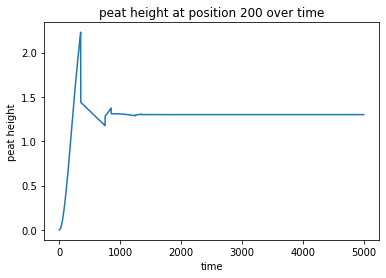

In [8]:
# Plot p of a given point in x

location_in_x = 200

plt.figure()
plt.plot(solution[:,location_in_x])
plt.title(f'peat height at position {location_in_x} over time')
plt.ylabel('peat height')
plt.xlabel('time')
plt.show()


# 2D Numerics

In [11]:
# Page 175 in Langtangen's book. Follow that!


def advance_vectorized(u, u_n, u_nm1, f_a, Cx2, Cy2, dt2,
    V=None, step1=False):
    if step1:
        dt = np.sqrt(dt2) # save
        Cx2 = 0.5*Cx2; Cy2 = 0.5*Cy2; dt2 = 0.5*dt2 # redefine
        D1 = 1; D2 = 0
    else:
        D1 = 2; D2 = 1
        u_xx = u_n[:-2,1:-1] - 2*u_n[1:-1,1:-1] + u_n[2:,1:-1]
        u_yy = u_n[1:-1,:-2] - 2*u_n[1:-1,1:-1] + u_n[1:-1,2:]
        u[1:-1,1:-1] = (D1*u_n[1:-1,1:-1] - D2*u_nm1[1:-1,1:-1] + 
            Cx2*u_xx + Cy2*u_yy + dt2*f_a[1:-1,1:-1])
    if step1:
        u[1:-1,1:-1] += dt*V[1:-1, 1:-1]
    # Boundary condition u=0
    u[:,0] = 0
    u[:,u.shape[1]-1] = 0
    u[0,:] = 0
    u[u.shape[0]-1,:] = 0
    
    return u

def run_all_timesteps_2D(u_new, u, u_old):
    solution = np.zeros(shape=(MAX_NITER, u.shape[0], u.shape[1]))
    solution[0] = u
    for niter in range(1, MAX_NITER):
        
        #solve
        u_new = advance_vectorized(u=u_new, u_n=u, u_nm1=u_old, f_a=f_ext,
                                   Cx2=c_squared*(dx/dt)**2, Cy2=c_squared*(dy/dt)**2,
                                   dt2=dt**2)
        solution[niter] = u_new
        
        u_old = u.copy()
        u = u_new.copy()
        
    return solution  

# Parameters
dx = 1. # m
dy = 1. #m
dt = 10

Lx = 1000 # m
Ly = Lx
MAX_NITER = int(100)
grid_length_x = int(Lx/dx)
grid_length_y = int(Ly/dy)
simulated_time = int(dt*MAX_NITER)

# 2D Mesh
x = np.linspace(0, Lx-1, grid_length_x)
y = np.linspace(0, Ly-1, grid_length_y)
xv = x.reshape((x.size,1))
yv = y.reshape((1, y.size))

b = 0.001 # friction term
c_squared = 1.0 # coefficient of wave
f_ext = 0.000001 + 0*xv*yv # external force


# Initial values
u_new = 0 * xv*yv # u at time n+1
u = 0 * xv*yv # u at time n
u_old = 0 * xv*yv # u at time n-1




In [12]:
# Run 2D
solution_2D = run_all_timesteps_2D(u_new=u_new, u=u, u_old=u_old)



In [ ]:
# Plot with matplotlib
# It is very slow. I tried to use Mayavi, but I couldn't install it in Colab
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(x,y)

ax.plot_surface(X=X, Y=Y, Z=solution_2D[50], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface')

Text(0.5, 0.92, 'surface')

In [24]:
X

array([[  0.,   1.,   2., ..., 997., 998., 999.],
       [  0.,   1.,   2., ..., 997., 998., 999.],
       [  0.,   1.,   2., ..., 997., 998., 999.],
       ...,
       [  0.,   1.,   2., ..., 997., 998., 999.],
       [  0.,   1.,   2., ..., 997., 998., 999.],
       [  0.,   1.,   2., ..., 997., 998., 999.]])